In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:14: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


## Specify dataset

In [43]:
# N-hot inputs
feature_maker_kwargs = {
    'feature_dim': 128, 'feature_type': 'nhot'
    }

# Uncorrelated inputs
feature_maker_kwargs = {
    'feature_dim': 100,
    'feature_vals': [0, 1],
    'feature_vals_p': [0.97, 0.03]
    }

# Correlated inputs
feature_maker_kwargs = {
    'feature_dim': 10, 'feature_vals': None,
    #'feature_vals_p': [0.95, 0.05],
    'feature_type': 'correlated_distributed',
    'spatial_sigma': 1.25
    }

dataset_config = {
    'num_steps': 2000, 'num_states': 10*10,
    'feature_maker_kwargs': feature_maker_kwargs
    }
dataset = sf_inputs_discrete.Sim2DWalk
input_size = feature_maker_kwargs['feature_dim']
seed = 3

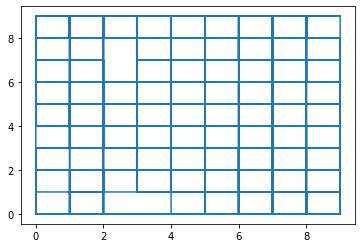

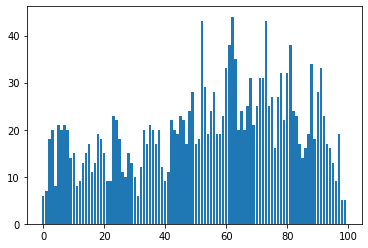

19.0


0.0

In [44]:
np.random.seed(seed)
input = dataset(**dataset_config)
plt.figure();
plt.plot(input.xs, input.ys)
plt.show()

plt.figure();
states = np.argwhere(input.state_inputs)[:,0]
counts = np.zeros(dataset_config['num_states'])
for state in np.arange(dataset_config['num_states']):
    counts[state] = np.sum(states==state)
plt.bar(np.arange(dataset_config['num_states']), counts)
plt.show()
print(np.median(counts))
np.sum(counts == 0)/dataset_config['num_states']

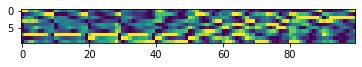

In [45]:
plt.figure()
plt.imshow(input.feature_maker.feature_map)
plt.show()

In [46]:
gamma=0.4

In [47]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)

# Plot RNN outputs

In [49]:
rnn = AnalyticSR(
    num_states=input_size, gamma=gamma,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr': 1E-3,
        'alpha': 1., 'beta': 1.
        }
    )
np.random.seed(seed)
outputs, loss = run_rnn(
    '../trained_models/test/', rnn, dataset,
    dataset_config, gamma=gamma
    )


[   51] loss: 0.041
Time per step 0.001s, net 0.042s

[  101] loss: 0.041
Time per step 0.001s, net 0.117s

[  151] loss: 0.040
Time per step 0.002s, net 0.223s

[  201] loss: 0.037
Time per step 0.003s, net 0.374s

[  251] loss: 0.033
Time per step 0.004s, net 0.554s

[  301] loss: 0.031
Time per step 0.004s, net 0.761s

[  351] loss: 0.028
Time per step 0.005s, net 1.002s

[  401] loss: 0.026
Time per step 0.006s, net 1.292s

[  451] loss: 0.024
Time per step 0.006s, net 1.603s

[  501] loss: 0.023
Time per step 0.007s, net 1.970s

[  551] loss: 0.021
Time per step 0.010s, net 2.471s

[  601] loss: 0.020
Time per step 0.009s, net 2.928s

[  651] loss: 0.020
Time per step 0.011s, net 3.457s

[  701] loss: 0.019
Time per step 0.011s, net 4.032s

[  751] loss: 0.019
Time per step 0.013s, net 4.692s

[  801] loss: 0.018
Time per step 0.013s, net 5.362s

[  851] loss: 0.018
Time per step 0.012s, net 5.965s

[  901] loss: 0.017
Time per step 0.014s, net 6.682s

[  951] loss: 0.017
Time pe

KeyboardInterrupt: 

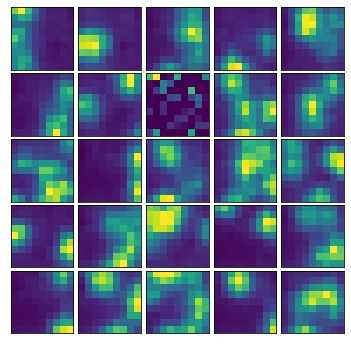

In [11]:
import matplotlib.gridspec as gridspec

grid_x = 5; grid_y = 5;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0    
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.show()

In [ ]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)
for neur in range(outputs.shape[1]):
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur].numpy())
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0
    plt.figure()
    plt.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    plt.colorbar()
    plt.show() 

# Plot Linear outputs

In [14]:
linear = Linear(input_size=input_size)
np.random.seed(seed)
outputs, loss = run_linear(
    '../trained_models/test/', linear, dataset,
    dataset_config, gamma=gamma, lr=1E-3
    )


[   51] loss: 0.087
Time per step 0.001s, net 0.055s

[  101] loss: 0.084
Time per step 0.003s, net 0.188s

[  151] loss: 0.078
Time per step 0.003s, net 0.348s

[  201] loss: 0.075
Time per step 0.005s, net 0.605s

[  251] loss: 0.073
Time per step 0.006s, net 0.904s

[  301] loss: 0.071
Time per step 0.008s, net 1.291s

[  351] loss: 0.070
Time per step 0.010s, net 1.773s

[  401] loss: 0.071
Time per step 0.021s, net 2.805s

[  451] loss: 0.071
Time per step 0.020s, net 3.828s

[  501] loss: 0.069
Time per step 0.016s, net 4.609s

[  551] loss: 0.069
Time per step 0.018s, net 5.517s

[  601] loss: 0.069
Time per step 0.019s, net 6.472s

[  651] loss: 0.069
Time per step 0.021s, net 7.498s

[  701] loss: 0.071
Time per step 0.023s, net 8.644s

[  751] loss: 0.072
Time per step 0.026s, net 9.931s

[  801] loss: 0.073
Time per step 0.027s, net 11.278s

[  851] loss: 0.073
Time per step 0.029s, net 12.739s

[  901] loss: 0.073
Time per step 0.033s, net 14.377s

[  951] loss: 0.074
Time

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


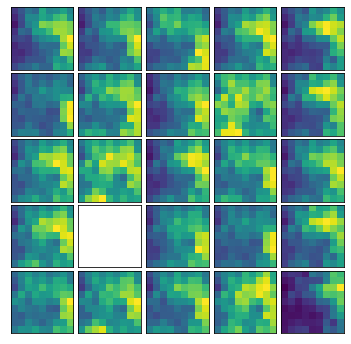

In [15]:
import matplotlib.gridspec as gridspec

grid_x = 5; grid_y = 5;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0    
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.show()

In [ ]:
for neur in range(outputs.shape[1]):
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0
    plt.figure()
    plt.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    plt.colorbar()
    plt.show() 

# Plot MLP outputs

In [48]:
mlp = MLP(input_size=input_size, hidden_size=input_size*2)
np.random.seed(seed)
outputs, loss = run_mlp(
    '../trained_models/test/', mlp, dataset,
    dataset_config, gamma=gamma
    )


[   51] loss: 0.263
Time per step 0.001s, net 0.061s

[  101] loss: 0.116
Time per step 0.001s, net 0.128s

[  151] loss: 0.080
Time per step 0.001s, net 0.199s

[  201] loss: 0.065
Time per step 0.002s, net 0.298s

[  251] loss: 0.054
Time per step 0.002s, net 0.415s

[  301] loss: 0.050
Time per step 0.002s, net 0.521s

[  351] loss: 0.041
Time per step 0.002s, net 0.631s

[  401] loss: 0.036
Time per step 0.002s, net 0.744s

[  451] loss: 0.032
Time per step 0.002s, net 0.869s

[  501] loss: 0.029
Time per step 0.003s, net 1.009s

[  551] loss: 0.026
Time per step 0.003s, net 1.143s

[  601] loss: 0.025
Time per step 0.003s, net 1.277s

[  651] loss: 0.022
Time per step 0.003s, net 1.412s

[  701] loss: 0.022
Time per step 0.003s, net 1.559s

[  751] loss: 0.022
Time per step 0.003s, net 1.701s

[  801] loss: 0.021
Time per step 0.003s, net 1.853s

[  851] loss: 0.020
Time per step 0.003s, net 2.011s

[  901] loss: 0.020
Time per step 0.004s, net 2.211s

[  951] loss: 0.019
Time pe

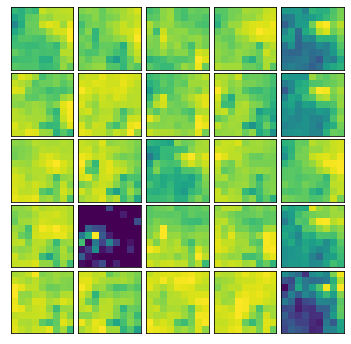

In [13]:
import matplotlib.gridspec as gridspec

grid_x = 5; grid_y = 5;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0    
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.show()

In [ ]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)
for neur in range(outputs.shape[1]):
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0
    plt.figure()
    plt.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    plt.colorbar()
    plt.show() 